In [1]:
# -*- coding: utf-8 -*-
# -*- authors : Vincent Roduit -*-
# -*- date : 2025-04-24 -*-
# -*- Last revision: 2025-05-02 by janzgraggen -*-
# -*- python version : 3.10.4 -*-
# -*- Description: Notebook that summarizes the main results-*-

# <center> EE-452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Graph-based EEG Analysis </center>
---

In [ ]:
#import libraries
import pandas as pd
from pathlib import Path
import sys

from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
from seiz_eeg.dataset import EEGDataset

#import modules
import constants
from transform_func import *
from dataloader import load_data
from utils import *


%load_ext autoreload
%autoreload 2

/home/nulpe/anaconda3/envs/ada/lib/python3.12/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


In [9]:
data_path = "../data"

DATA_ROOT = Path(data_path)

clips_train = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_test = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

# You can change the signal_transform, or remove it completely
data_train = EEGDataset(
    clips_train,
    signals_root=DATA_ROOT / "train",
    signal_transform=None,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

data_test = EEGDataset(
    clips_test,
    signals_root=DATA_ROOT / "test",
    signal_transform=None,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [45]:
clips_train
# Count how often the label is 0 and 1 in clips_train
label_counts = clips_train['label'].value_counts()
print(label_counts)
10476/(10476+2517)

label
0    10476
1     2517
Name: count, dtype: int64


0.8062803047794966

In [23]:
# Prepare the multi-index DataFrame
import pandas as pd

def get_summary_stats(df):
    df = df.reset_index()
    sessions_per_patient = df.groupby('patient')['session'].nunique()
    segments_per_session = df.groupby(['patient', 'session']).size()
    return {
        'Number of patients': df['patient'].nunique(),
        'sessions_per_patient': {
            'mean': sessions_per_patient.mean(),
            'median': sessions_per_patient.median(),
            'min': sessions_per_patient.min(),
            'max': sessions_per_patient.max()
        },
        'segments_per_session': {
            'mean': segments_per_session.mean(),
            'median': segments_per_session.median(),
            'min': segments_per_session.min(),
            'max': segments_per_session.max()
        }
    }

train_stats = get_summary_stats(clips_train)
test_stats = get_summary_stats(clips_test)

# Build the multi-index table
arrays = [
    ['Train', 'Train', 'Test', 'Test'],
    [train_stats['Number of patients'], train_stats['Number of patients'],
     test_stats['Number of patients'], test_stats['Number of patients']],
    ['sessions_per_patient', 'segments_per_session', 'sessions_per_patient', 'segments_per_session']
]
index = pd.MultiIndex.from_arrays(arrays, names=['Set', 'Number of patients', 'Statistic'])

data = [
    [train_stats['sessions_per_patient']['mean'], train_stats['sessions_per_patient']['median'],
     train_stats['sessions_per_patient']['min'], train_stats['sessions_per_patient']['max']],
    [train_stats['segments_per_session']['mean'], train_stats['segments_per_session']['median'],
     train_stats['segments_per_session']['min'], train_stats['segments_per_session']['max']],
    [test_stats['sessions_per_patient']['mean'], test_stats['sessions_per_patient']['median'],
     test_stats['sessions_per_patient']['min'], test_stats['sessions_per_patient']['max']],
    [test_stats['segments_per_session']['mean'], test_stats['segments_per_session']['median'],
     test_stats['segments_per_session']['min'], test_stats['segments_per_session']['max']],
]

summary = pd.DataFrame(data, index=index, columns=['Mean', 'Median', 'Min', 'Max'])

# Output as LaTeX table
print(summary.to_latex(float_format="%.2f"))

\begin{tabular}{lllrrrr}
\toprule
 &  &  & Mean & Median & Min & Max \\
Set & Number of patients & Statistic &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Train} & \multirow[t]{2}{*}{97} & sessions_per_patient & 1.82 & 1.00 & 1 & 7 \\
 &  & segments_per_session & 73.41 & 62.00 & 1 & 285 \\
\cline{1-7} \cline{2-7}
\multirow[t]{2}{*}{Test} & \multirow[t]{2}{*}{25} & sessions_per_patient & 2.00 & 1.00 & 1 & 7 \\
 &  & segments_per_session & 72.28 & 54.00 & 3 & 470 \\
\cline{1-7} \cline{2-7}
\bottomrule
\end{tabular}



In [ ]:
val_indices = [i for i in range(len(data_train)) if not is_mostly_zero_record(data_train[i][0])]
dataset_cleaned = torch.utils.data.Subset(data_train, val_indices)


In [100]:
arr = data_train[0][0].sum(axis=1)  # shape: (channels, time)
num_zeros = (arr == 0).sum()
num_nonzeros = (arr != 0).sum()
print(f"Number of zeros: {num_zeros}")
print(f"Number of non-zeros: {num_nonzeros}")

Number of zeros: 2239
Number of non-zeros: 761


In [103]:
def is_mostly_zero_record(eeg, threshold=0.2):
  
    signal_magnitude = np.sum(np.abs(eeg), axis=1)
    length = len(signal_magnitude)
    zeros = (signal_magnitude== 0).sum()

    return (zeros / length) > threshold


is_mostly_zero_record(data_train[0][0])

True

In [91]:
761/(2239+761)

0.25366666666666665

In [80]:
len(data_train.get_label_array())

12993

In [81]:
lables = dataset_cleaned.dataset.get_label_array()
len(lables)

12993

In [ ]:
labels = dataset_cleaned.get_label_array()

#get idx of class 0
idx_class_0 = np.where(labels == 0)[0]
idx_class_1 = np.where(labels == 1)[0]

12993

In [ ]:
eeg_0 = dataset_tr[idx_class_0[0]][0].T
eeg_1 = dataset_tr[idx_class_1[0]][0].T



0

In [48]:
import mne


def create_mne_signal(eeg, sfreq, ch_names):
    """
    Create an MNE Raw object from EEG data.
    
    Parameters:
    eeg (numpy.ndarray): EEG data with shape (n_channels, n_samples).
    sfreq (float): Sampling frequency in Hz.
    ch_names (list of str): List of channel names.
    
    Returns:
    mne.io.Raw: MNE Raw object containing the EEG data.
    """
    eeg = eeg * 1e-6
    # Create MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))
    # Create Raw object
    raw = mne.io.RawArray(eeg, info, verbose=False)
    # Set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, verbose=False)
    return raw

def plot_eeg_sensors(eeg, sfreq, ch_names, title='EEG Topomap'):
    raw = create_mne_signal(eeg, sfreq, ch_names)
    
    # Plot sensors and get the figure
    fig = mne.viz.plot_sensors(raw.info, kind='topomap', show_names=True, show=True)
    
    # Add title to the actual figure
    fig.suptitle(title, fontsize=14)
    
    return fig

def plot_signal(eeg, sfreq, ch_names):
    n_channels = eeg.shape[0]
    raw = create_mne_signal(eeg, sfreq, ch_names=ch_names)
    raw.plot(n_channels=n_channels,duration=12, show_scrollbars=False, title='EEG Recording with 10-20 Montage');

def plot_topo(eeg, sfreq, ch_names):
    """
    Plot the topographic map of EEG sensors.
    
    Parameters:
    raw (mne.io.Raw): MNE Raw object containing the EEG data.
    """
    raw = create_mne_signal(eeg, sfreq, ch_names)
    spectrum = raw.compute_psd()
    fig = spectrum.plot_topomap()

    return fig
# Plot the EEG signal

In [49]:
ch_names = [
        'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
        'T7', 'C3', 'Cz', 'C4', 'T8',
        'P7', 'P3', 'Pz', 'P4', 'P8',
        'O1', 'O2'
    ]
raw0 = create_mne_signal(eeg_0, 250, ch_names=ch_names)
raw1 = create_mne_signal(eeg_1, 250, ch_names=ch_names)

Plotting power spectral density (dB=True).


/home/nulpe/anaconda3/envs/ada/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).


/tmp/ipykernel_796854/4220317208.py:3: UserWarning: Zero value in spectrum for channels Fp1, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, Pz, P4, P8, O1, O2
  fig = raw1.compute_psd(verbose=False).plot();
/tmp/ipykernel_796854/4220317208.py:3: UserWarning: Infinite value in PSD for channels Fp1, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, Pz, P4, P8, O1, O2.
These channels might be dead.
  fig = raw1.compute_psd(verbose=False).plot();
/home/nulpe/anaconda3/envs/ada/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


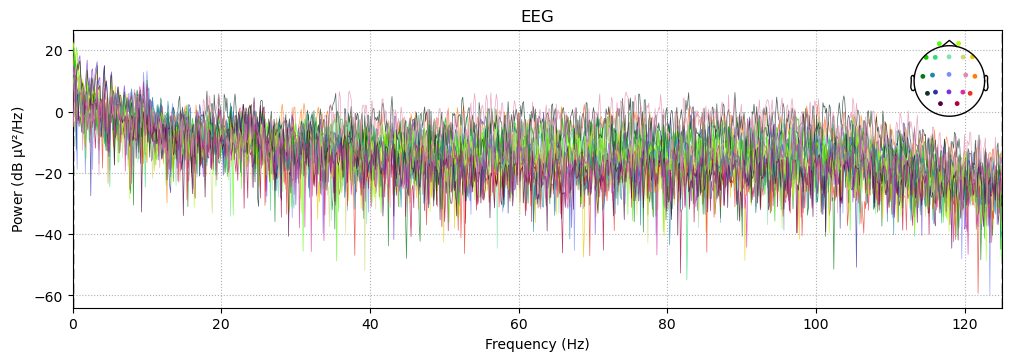

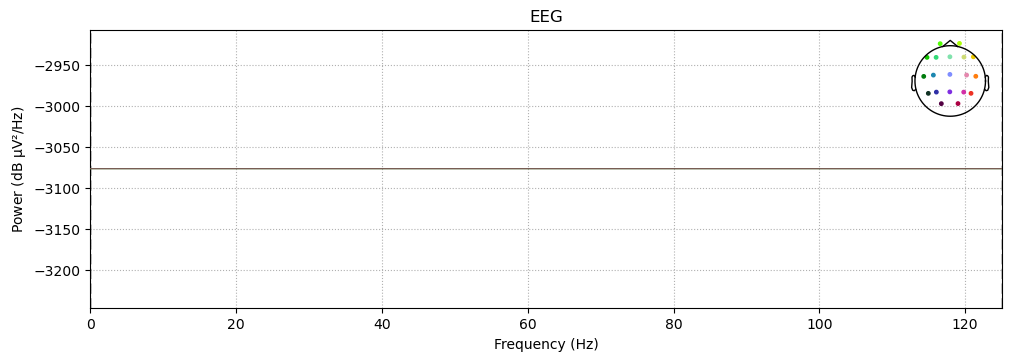

In [50]:
fig = raw0.compute_psd(verbose=False).plot();
fig.savefig("psd_class_0.png")
fig = raw1.compute_psd(verbose=False).plot();
fig.savefig("psd_class_1.png")

In [52]:
eeg_1[0]

array([ 0.        ,  0.        ,  0.        , ..., 31.01551256,
       31.64192633, 35.689523  ])

In [53]:
raw0.compute_psd().plot();

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/home/nulpe/anaconda3/envs/ada/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


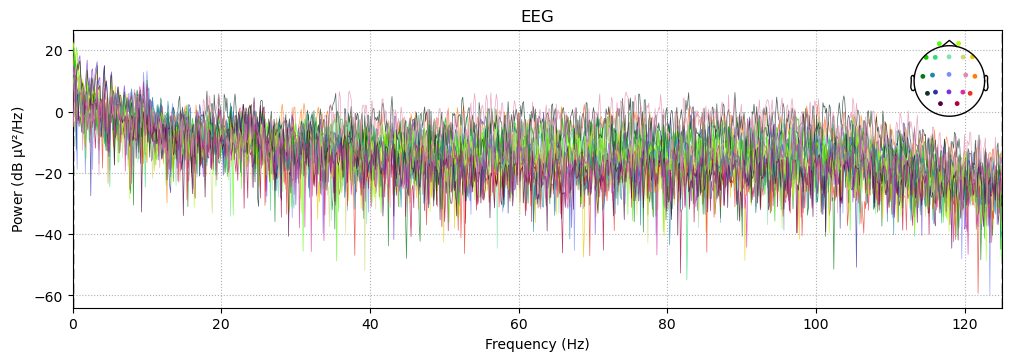

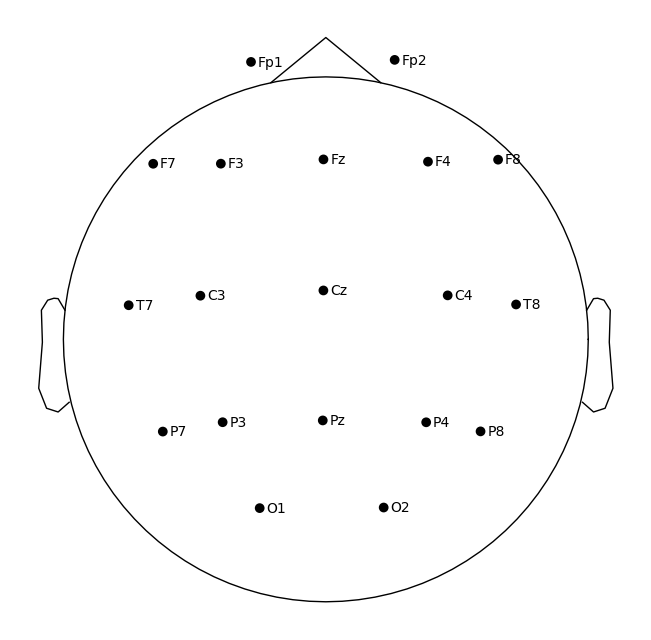

In [54]:

sfreq = 250  # Sampling frequency in Hz
plot_eeg_sensors(eeg_0, sfreq, ch_names=ch_names);

Effective window size : 8.192 (s)


/tmp/ipykernel_796854/453891287.py:50: UserWarning: Zero value in spectrum for channels Fp1, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, Pz, P4, P8, O1, O2
  spectrum = raw.compute_psd()


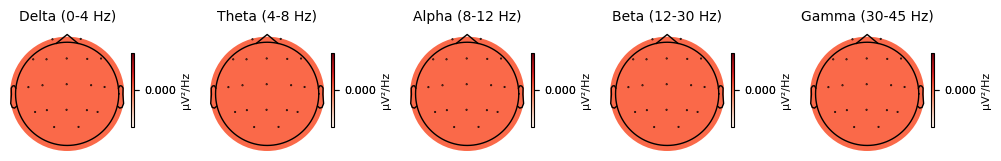

Effective window size : 8.192 (s)


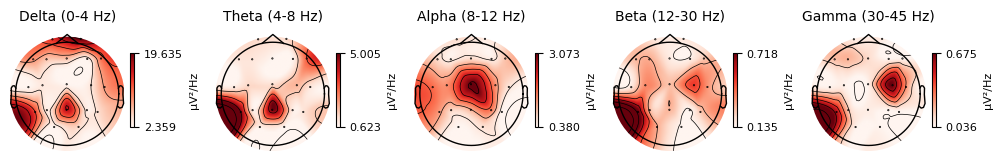

In [57]:
plot_topo(eeg_1, sfreq, ch_names=ch_names);

plot_topo(eeg_0, sfreq, ch_names=ch_names);


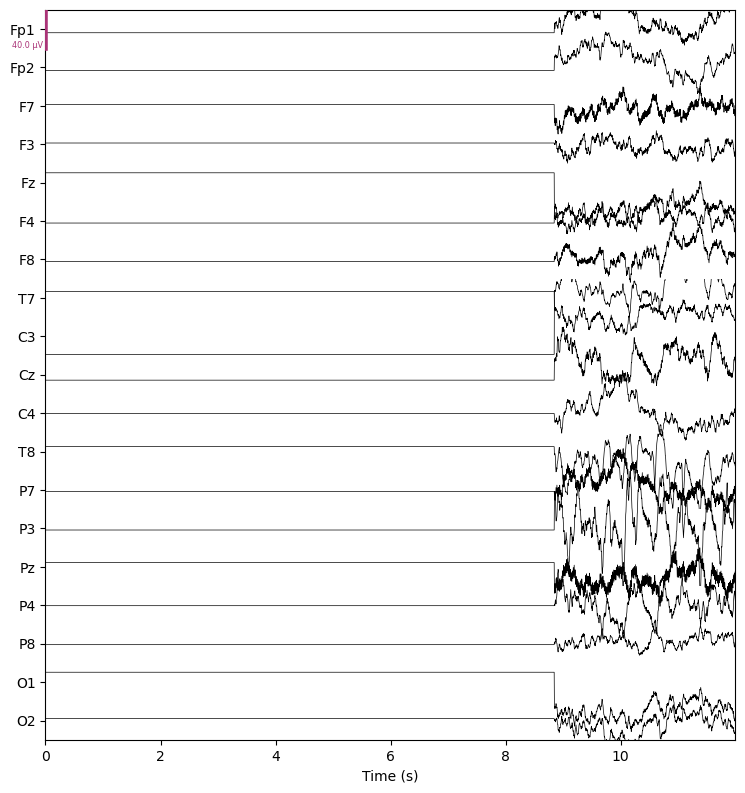

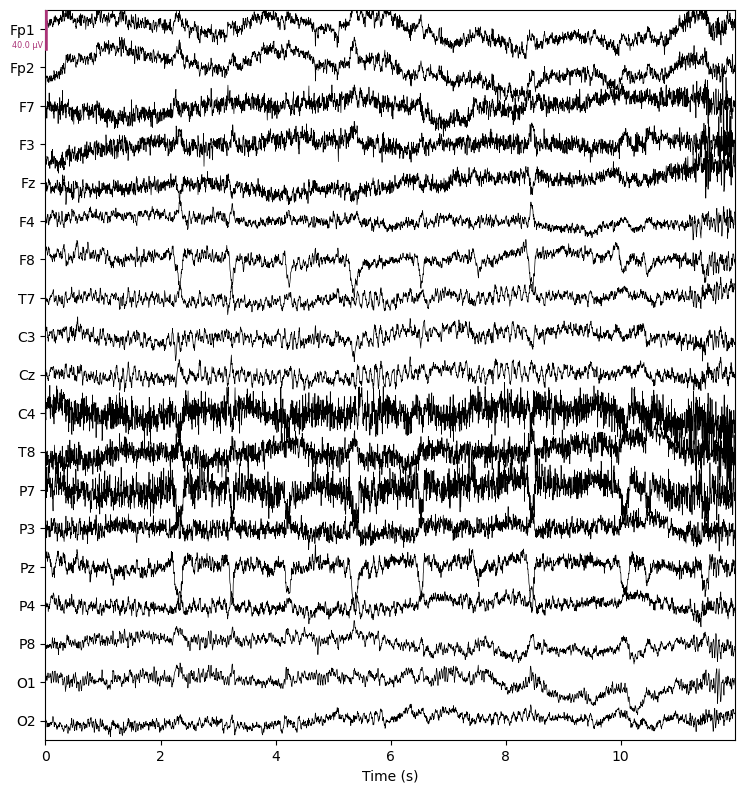

In [56]:
plot_signal(eeg_1, sfreq, ch_names=ch_names);
plot_signal(eeg_0, sfreq, ch_names=ch_names);

In [63]:
import numpy as np

def is_mostly_zero_record(eeg, threshold=0.2):
    """
    eeg: np.ndarray of shape (channels, time)
    threshold: fraction of the signal length that can be zero before we discard
    Returns True if the signal is mostly zeros at the beginning
    """
    # Sum absolute signal across channels => shape: (time,)
    signal_magnitude = np.sum(np.abs(eeg), axis=0)
    cumsum = np.cumsum(signal_magnitude)
    total = cumsum[-1]
    if total == 0:
        return True  # fully zero record

    # Find when at least 1% of total energy has accumulated
    start_idx = np.argmax(cumsum >= 0.01 * total)
    return (start_idx / eeg.shape[1]) > threshold

In [72]:
clips_tr

label  start_time  end_time       date  \
patient  session   segment                                           
pqejgcff s001_t000 0            1         0.0      12.0 2003-01-01   
                   1            1        12.0      24.0 2003-01-01   
                   2            1        24.0      36.0 2003-01-01   
                   3            1        36.0      48.0 2003-01-01   
                   4            1        48.0      60.0 2003-01-01   
...                           ...         ...       ...        ...   
pqejgvqb s001_t013 8            1        96.0     108.0 2015-01-01   
                   9            1       108.0     120.0 2015-01-01   
                   10           1       120.0     132.0 2015-01-01   
                   11           1       132.0     144.0 2015-01-01   
                   12           0       144.0     156.0 2015-01-01   

                            sampling_rate                        signals_path  
patient  session   segment                                                     
pqejgcff s001_t000 0                  250  signals/pqejgcff_s001_t000.parquet  
                   1                  250  signals/pqejgcff_s001_t000.parquet  
                   2                  250  signals/pqejgcff_s001_t000.parquet  
                   3                  250  signals/pqejgcff_s001_t000.parquet  
                   4                  250  signals/pqejgcff_s001_t000.parquet  
...                                   ...                                 ...  
pqejgvqb s001_t013 8                  250  signals/pqejgvqb_s001_t013.parquet  
                   9                  250  signals/pqejgvqb_s001_t013.parquet  
                   10                 250  signals/pqejgvqb_s001_t013.parquet  
                   11                 250  signals/pqejgvqb_s001_t013.parquet  
                   12                 250  signals/pqejgvqb_s001_t013.parquet  

[12993 rows x 6 columns]

In [67]:
eeg_1 = dataset_tr[idx_class_1[1]][0].T
records_to_keep = [idx for idx in idx_class_0 if not is_mostly_zero_record(dataset_tr[idx][0].T)]
records_to_delete = [idx for idx in idx_class_0 if is_mostly_zero_record(dataset_tr[idx][0].T)]

In [70]:
len(records_to_delete)

32

In [ ]:
dataset_tr[4777]

(array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ 65.13097018, -10.2474868 ,   4.40095828, ...,  20.880459  ,
         -56.32905362, -37.10296945],
        [ 74.36655782,  -1.92742698,   6.00714743, ...,  16.07795343,
         -62.65743889, -46.78829005],
        [ 75.52301401,   0.44973296,   3.19631642, ...,  15.70852992,
         -68.5200293 , -51.73535264]]),
 0)

: 